In [26]:
# Step 1. Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Step 2. Load data
df = pd.read_csv("snap_qc_data_2017to2023.csv", encoding = "latin1")

# Step 3. Keep only needed columns
keep_cols = ['State', 'Year', 'Error Element']
df = df[keep_cols].copy()

# Step 4. Drop missing values & clean datatypes
df = df.dropna(subset=['State', 'Year', 'Error Element'])
df['Year'] = df['Year'].astype(int)

print("✅ Cleaned data shape:", df.shape)
print(df.head())



✅ Cleaned data shape: (72072, 3)
         State  Year       Error Element
0  Connecticut  2017  Wages and salaries
1  Connecticut  2017   Shelter deduction
2  Connecticut  2017  Wages and salaries
3  Connecticut  2017  Wages and salaries
4  Connecticut  2017  Wages and salaries


In [20]:

# Step 5. Aggregate data: count # of errors by state-year-element
agg = df.groupby(['State', 'Year', 'Error Element']).size().reset_index(name='Error Count')

# Step 6. Build model: predict 2024 per state-element
predictions = []

for (state, elem), subdf in agg.groupby(['State', 'Error Element']):
    if len(subdf['Year'].unique()) >= 3 and subdf['Error Count'].std() > 0:  # require at least 3 data points
        X = sm.add_constant(subdf['Year'])
        y = subdf['Error Count']
        model = sm.OLS(y, X).fit()
        
        # Predict 2024
        y_pred_2024 = model.predict([1, 2024])[0]
        predictions.append({
            'State': state,
            'Error Element': elem,
            'Predicted_2024': max(y_pred_2024, 0),  # avoid negative
            'R2': model.rsquared,
            'p_value': model.pvalues['Year']
        })

pred_df = pd.DataFrame(predictions)
print("\n📈 Predicted 2024 Error Counts by State and Element:")
print(pred_df.head())

# Step 7. Summary stats
print("\n🔍 Statistical Summary:")
print(pred_df[['R2', 'p_value']].describe())



📈 Predicted 2024 Error Counts by State and Element:
     State                                      Error Element  Predicted_2024  \
0  Alabama                    Child support payment deduction        3.142857   
1  Alabama  Child support payments received from absent pa...        8.000000   
2  Alabama                                      Contributions        4.571429   
3  Alabama                           Dependent care deduction        2.000000   
4  Alabama                         Medical expense deductions        5.354037   

         R2   p_value  
0  0.571429  0.454371  
1  0.001176  0.941805  
2  0.510417  0.071257  
3  0.015152  0.792613  
4  0.083506  0.578605  

🔍 Statistical Summary:
                 R2       p_value
count  9.670000e+02  9.670000e+02
mean   2.681972e-01  4.496008e-01
std    2.583142e-01  2.930097e-01
min   -2.220446e-16  8.864126e-14
25%    4.459386e-02  1.957165e-01
50%    1.860465e-01  4.144301e-01
75%    4.286685e-01  6.988116e-01
max    1.000000e+00 

D:\soft\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


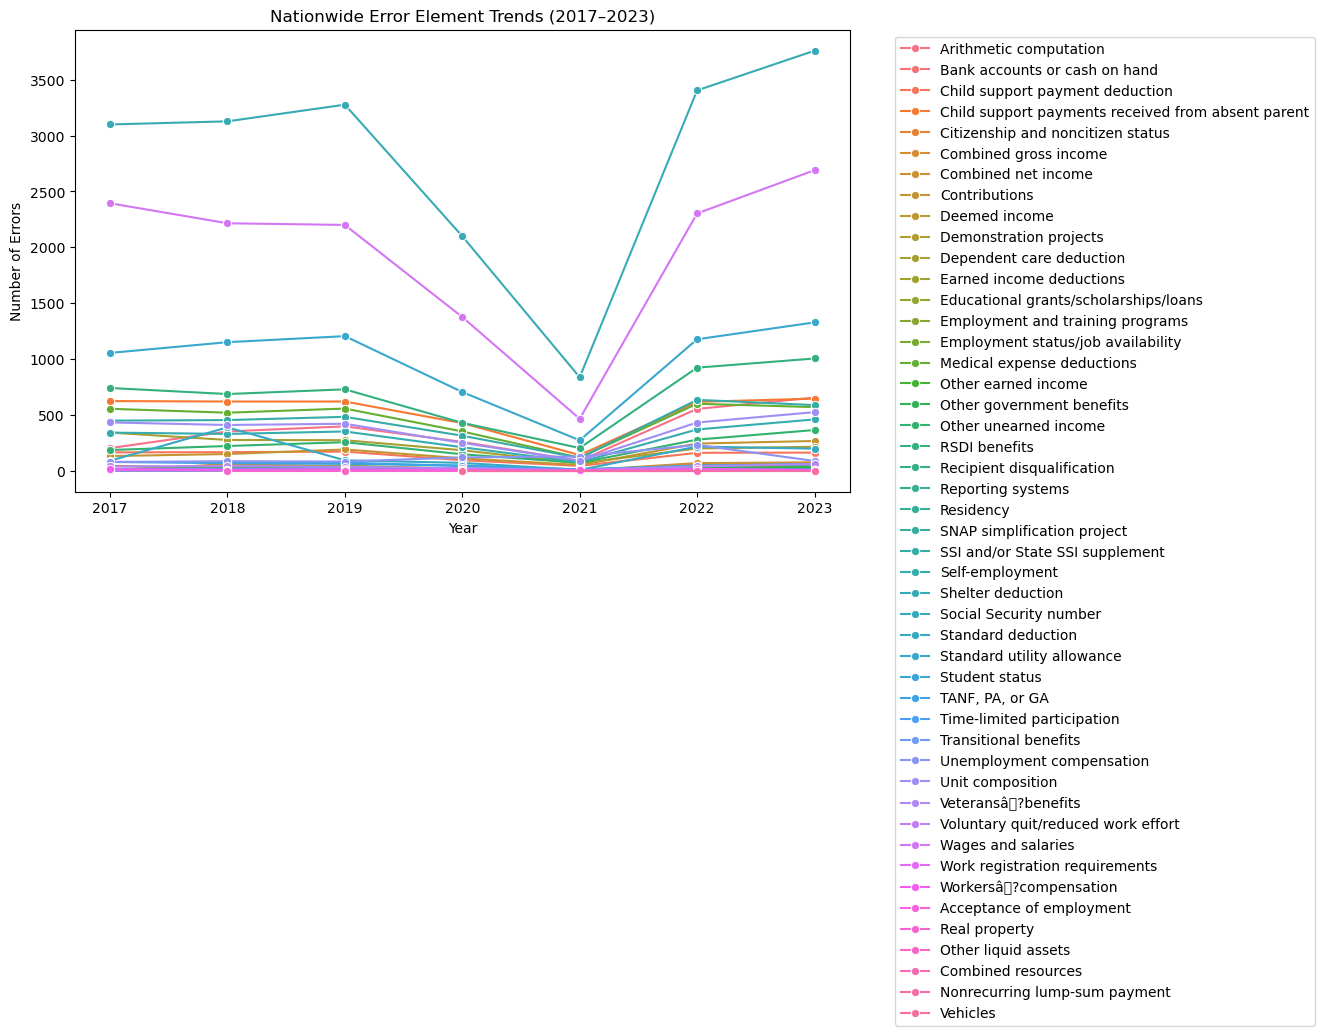

📊 Trend Analysis Results:
                                        Error Element  coef_year   p_value  \
10                           Dependent care deduction -26.464286  0.113576   
37                                 Wages and salaries -23.964286  0.885791   
3   Child support payments received from absent pa... -14.964286  0.709646   
14                         Medical expense deductions  -8.392857  0.824551   
30                                    TANF, PA, or GA  -6.285714  0.191410   
29                                     Student status  -5.964286  0.161034   
2                     Child support payment deduction  -5.214286  0.621940   
27                                 Standard deduction  -3.785714  0.891042   
31                         Time-limited participation  -3.214286  0.003280   
28                         Standard utility allowance  -2.178571  0.978399   

                   trend  
10  No significant trend  
37  No significant trend  
3   No significant trend  
14  No 

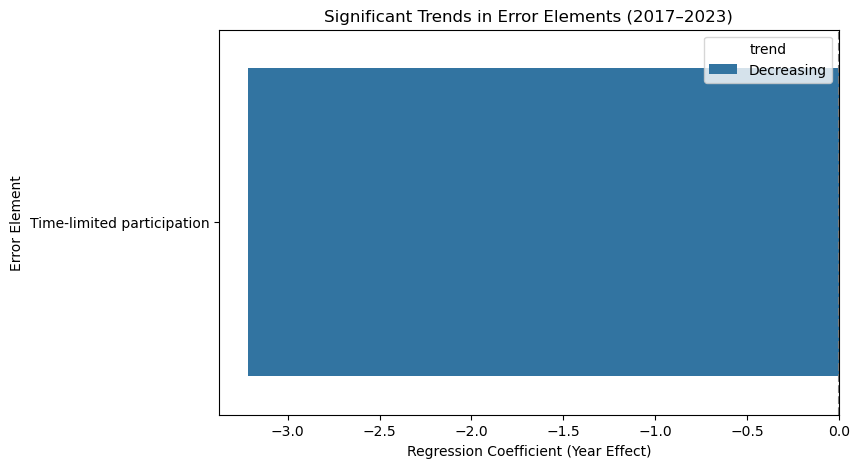

In [30]:
# 聚合到全国层面
agg = df.groupby(['Year', 'Error Element']).size().reset_index(name='count')

# Step 2. 可视化总体趋势
plt.figure(figsize=(10,6))
sns.lineplot(data=agg, x='Year', y='count', hue='Error Element', marker='o')
plt.title("Nationwide Error Element Trends (2017–2023)")
plt.ylabel("Number of Errors")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 3. 对每个错误类型进行线性回归
results = []
for elem, g in agg.groupby('Error Element'):
    if len(g['Year'].unique()) >= 4:  # 至少4个时间点
        X = sm.add_constant(g['Year'])
        y = g['count']
        model = sm.OLS(y, X).fit()
        coef = model.params['Year']
        pval = model.pvalues['Year']
        results.append({
            'Error Element': elem,
            'coef_year': coef,
            'p_value': pval,
            'trend': 'Increasing' if (coef > 0 and pval < 0.05)
                      else 'Decreasing' if (coef < 0 and pval < 0.05)
                      else 'No significant trend'
        })

trend_df = pd.DataFrame(results)
trend_df = trend_df.sort_values(by='coef_year', ascending=True)
print("📊 Trend Analysis Results:")
print(trend_df.head(10))

# Step 4. 可视化显著上升/下降的类别
sig = trend_df[trend_df['p_value'] < 0.05]
plt.figure(figsize=(8,5))
sns.barplot(data=sig, x='coef_year', y='Error Element', hue='trend')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Significant Trends in Error Elements (2017–2023)")
plt.xlabel("Regression Coefficient (Year Effect)")
plt.show()


Between 2017 and 2023, the overall distribution of SNAP error elements remained relatively stable at the national level.
Linear trend analysis revealed that most error elements exhibited no statistically significant upward or downward changes (p>0.05), indicating the absence of systematic shifts in the composition of QC errors.
The only category that showed a significant downward trend was Time-limited participation, which likely reflects policy waivers during the COVID-19 public health emergency that temporarily suspended time limits for SNAP eligibility among able-bodied adults without dependents (ABAWDs).
This suggests that administrative and policy changes were effectively captured in the QC data, but no broad deterioration or improvement in other error categories was observed.

C:\Users\27311\AppData\Local\Temp\ipykernel_15896\1564594538.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary.reset_index(), x='net_increase', y='State', palette='coolwarm')


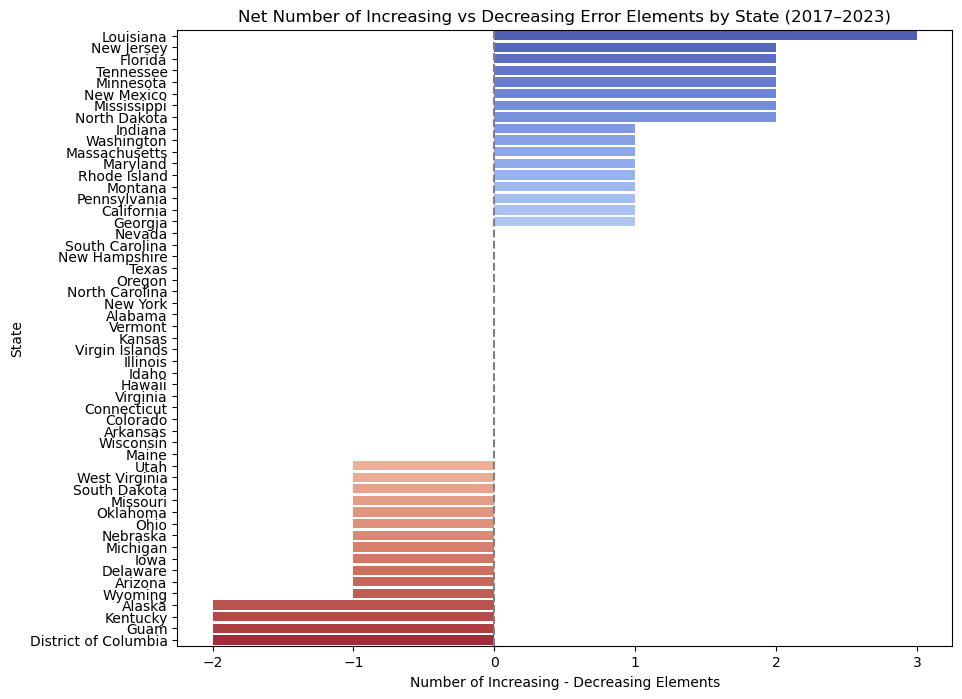

📊 Example of Significant Trends:
                    State                                      Error Element  \
15                 Alaska  Child support payments received from absent pa...   
27                 Alaska                                 Wages and salaries   
35                Arizona                    SSI and/or State SSI supplement   
62             California                                      Contributions   
73             California                                     Student status   
75             California                          Unemployment compensation   
114              Delaware                             Arithmetic computation   
141  District of Columbia                         Medical expense deductions   
144  District of Columbia                                      RSDI benefits   
166               Florida                         Standard utility allowance   

     coef_year   p_value       trend  
15   -0.714286  0.034317  Decreasing  
27   -2.

In [37]:
# Step 1. 数据读取与聚合
df = pd.read_csv("snap_qc_data_2017to2023.csv", encoding = "latin1")
df = df[['State', 'Year', 'Error Element']].dropna()
df['Year'] = df['Year'].astype(int)

# 每州每年每错误类型的数量
agg = df.groupby(['State', 'Year', 'Error Element']).size().reset_index(name='error_count')

# Step 2. 州级回归分析
results = []
for (state, elem), g in agg.groupby(['State', 'Error Element']):
    if len(g['Year'].unique()) >= 4 and g['error_count'].std() > 0:
        X = sm.add_constant(g['Year'])
        y = g['error_count']
        model = sm.OLS(y, X).fit()
        coef = model.params['Year']
        pval = model.pvalues['Year']
        results.append({
            'State': state,
            'Error Element': elem,
            'coef_year': coef,
            'p_value': pval,
            'trend': 'Increasing' if (coef > 0 and pval < 0.05)
                     else 'Decreasing' if (coef < 0 and pval < 0.05)
                     else 'Stable'
        })

trend_state_df = pd.DataFrame(results)

# Step 3. 汇总每州显著趋势数量
summary = trend_state_df.groupby(['State', 'trend']).size().unstack(fill_value=0)
summary['net_increase'] = summary.get('Increasing', 0) - summary.get('Decreasing', 0)
summary = summary.sort_values('net_increase', ascending=False)

# Step 4. 可视化
plt.figure(figsize=(10,8))
sns.barplot(data=summary.reset_index(), x='net_increase', y='State', palette='coolwarm')
plt.title("Net Number of Increasing vs Decreasing Error Elements by State (2017–2023)")
plt.xlabel("Number of Increasing - Decreasing Elements")
plt.ylabel("State")
plt.axvline(0, color='gray', linestyle='--')
plt.show()

# Step 5. 输出显著趋势样例
print("📊 Example of Significant Trends:")
print(trend_state_df[trend_state_df['p_value'] < 0.05].head(10))
